In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning_improved import *
from collections import Counter


/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load data
---

In [2]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

# EDD
---

In [3]:
# # Load your precomputed z-score spreads and raw prices as NumPy arrays

# window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!


# sym1, sym2 = prices.columns
# S1 = prices[sym1]
# S2 = prices[sym2]

# print("Computing spread series and beta series...")
# # Compute the spread series and beta_series 
# spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
# #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# # Compute rolling z-score using the provided helper function.
# zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# #Drop NaN values from zscore_series
# zscore_series = zscore_series.dropna()

# #Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
# prices = prices.loc[zscore_series.index]
# beta_series = beta_series.loc[zscore_series.index]


In [4]:
# # 1) Prepare a DataFrame to collect per‐cycle features

# spreads = zscore_series


# records = []
# for period, month_df in spreads.groupby(spreads.index.to_period("M")):
#     # slice out that month’s data
#     z = spreads[spreads.index.to_period("M") == period]
#     p = prices.loc[z.index]
#     b = beta_series.loc[z.index]

#     # build a mini‐env just to extract cycles
#     env = PairsTradingEnv(z, p, b, initial_capital=1.0, tx_cost=0.0, entry_stop_pairs=[(1,2)])
#     env.create_cycles(min_threshold=1.0, tol=0.10)

#     # for each cycle, grab summary stats
#     for cycle in env.spread_cycles:
#         records.append({
#             "month": str(period),
#             "entry_z": cycle.iloc[0],
#             "cycle_mean": cycle.mean(),
#             "cycle_std": cycle.std(),
#             "cycle_length": len(cycle),
#             "cycle_min": cycle.min(),
#             "cycle_max": cycle.max(),
#             "Absolute max": max(cycle.max(), abs(cycle.min())),
#         })

# df_cycles = pd.DataFrame(records)

In [5]:
# df_cycles

In [6]:

# # 2) Look at how entry_z distributions shift month→month
# plt.figure(figsize=(10,6))
# df_cycles.boxplot(column="entry_z", by="month", rot=45)
# plt.title("Distribution of Cycle Entry Z‐Scores by Month")
# plt.suptitle(""); plt.ylabel("Entry Z-Score")
# plt.tight_layout()
# plt.show()

# # 3) Similarly you can do cycle_length, cycle_std, etc.
# for feat in ["cycle_length","cycle_std","cycle_min","cycle_max"]:
#     plt.figure(figsize=(10,4))
#     df_cycles.boxplot(column=feat, by="month", rot=45)
#     plt.title(f"{feat} by Month")
#     plt.suptitle(""); plt.ylabel(feat)
#     plt.tight_layout()
#     plt.show()

# # 4) Or even a heatmap of mean/std per month
# summary = df_cycles.groupby("month")[["entry_z","cycle_length","cycle_std"]].agg(["mean","std"])
# print(summary)


* ## Training set

---

In [7]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


---

* ## Validation set

---

In [8]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-30 23:55:00'] #May val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


In [9]:
prices_val

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-05-03 00:00:00,0.4315,0.4341
2024-05-03 00:05:00,0.4323,0.4352
2024-05-03 00:10:00,0.4324,0.4348
2024-05-03 00:15:00,0.4316,0.4339
2024-05-03 00:20:00,0.4315,0.4335
...,...,...
2024-05-30 23:35:00,0.4454,0.4386
2024-05-30 23:40:00,0.4452,0.4386
2024-05-30 23:45:00,0.4457,0.4389


---

* ## Test set

---

In [10]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00']


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


In [11]:
prices_test

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-06-03 01:15:00,0.4433,0.4378
2024-06-03 01:20:00,0.4458,0.4400
2024-06-03 01:25:00,0.4464,0.4407
2024-06-03 01:30:00,0.4474,0.4424
2024-06-03 01:35:00,0.4468,0.4416
...,...,...
2024-06-29 23:20:00,0.3312,0.3263
2024-06-29 23:35:00,0.3311,0.3261
2024-06-29 23:40:00,0.3307,0.3259


---

# Train agent
---

In [12]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7,8.5)]
# Training parameters
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
                                                                                        zscore_series_train, 
                                                                                        prices_train, 
                                                                                        beta_series_train,
                                                                                        zscore_series_val,
                                                                                        prices_val,
                                                                                        beta_series_val,
                                                                                        initial_capital,
                                                                                        tx_cost,
                                                                                        entry_stop_pairs, 
                                                                                        num_epochs=500,
                                                                                        batch_size=32,
                                                                                        gamma = 0.99,
                                                                                        lr = 0.001,
                                                                                        epsilon_start = 1,
                                                                                        epsilon_end = 0.01,
                                                                                        epsilon_decay = 0.995,
                                                                                        replay_capacity = 1000,
                                                                                        target_update_freq = 10,
                                                                                        hidden_dim = 64,                                           
                                                                                        )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
503
Number of cycles: 503
Epoch 01 | AvgReward: -0.69 | Epsilon: 0.995
131
Epoch 02 | AvgReward: -0.77 | Epsilon: 0.990
131
Epoch 03 | AvgReward: -0.66 | Epsilon: 0.985
131
Epoch 04 | AvgReward: -0.70 | Epsilon: 0.980
131
Epoch 05 | AvgReward: -0.70 | Epsilon: 0.975
131
Epoch 06 | AvgReward: -0.72 | Epsilon: 0.970
131
Epoch 07 | AvgReward: -0.66 | Epsilon: 0.966
131
Epoch 08 | AvgReward: -0.67 | Epsilon: 0.961
131
Epoch 09 | AvgReward: -0.69 | Epsilon: 0.956
131
Epoch 10 | AvgReward: -0.65 | Epsilon: 0.951
131
Epoch 11 | AvgReward: -0.67 | Epsilon: 0.946
131
Epoch 12 | AvgReward: -0.71 | Epsilon: 0.942
131
Epoch 13 | AvgReward: -0.64 | Epsilon: 0.937
131
Epoch 14 | AvgReward: -0.65 | Epsilon: 0.932
131
Epoch 15 | AvgReward: -0.65 | Epsilon: 0.928
131
Epoch 16 | AvgReward: -0.65 | Epsilon: 0.923
131
Epoch 17 | AvgReward: -0.60 | Epsilon: 0.918
131
Epoch 18 | AvgReward: -0.60 | Epsilon: 0.914
131
Epoch 19 | AvgReward: -0.63 | Epsilon: 0.909
131
Epoch 20 | AvgReward:

# Best thresholds
---

503
503
Counter({(1, 2): 301, (2, 3): 127, (3, 4): 60, (4, 5): 12, (5, 6): 2, (7, 8.5): 1})


Text(0.5, 1.0, 'Oracle‐best Entry–Stop Pair Coverage (Training set)')

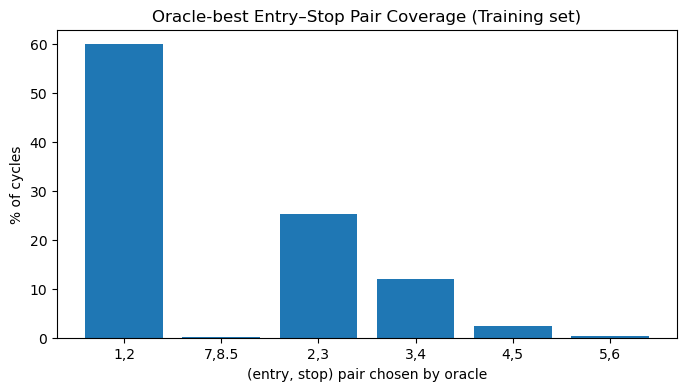

In [13]:
env = PairsTradingEnv(zscore_series_train, prices_train, beta_series_train, initial_capital, tx_cost, entry_stop_pairs)
best_pairs_train = env.find_best_thresholds()
spread_cycles_train = env.spread_cycles

#best_pairs_train = find_best_thresholds(entry_stop_pairs,zscore_series_train,prices_train,beta_series_train)

# Suppose best_pairs is your list of length N containing either (e,s) or None
counts = Counter(best_pairs_train)   # Now counts[None] is how many cycles had no winning pair
total  = len(best_pairs_train)

# Convert raw counts to percentages
pairs    = list(counts.keys())
percent_train  = [counts[p] / total * 100 for p in pairs]

# Turn None → a string label
labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in pairs
]

print(counts)

# Plot
plt.figure(figsize=(8,4))
bars = plt.bar(range(len(labels)), percent_train, tick_label=labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair chosen by oracle")
plt.title("Oracle‐best Entry–Stop Pair Coverage (Training set)")




Text(0.5, 1.0, 'Z-Score Series with Cycles illustration (for training set)')

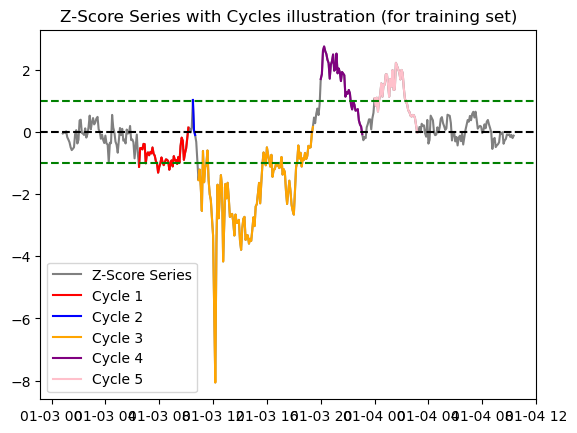

In [14]:
plt.plot(zscore_series_train.iloc[0:400], color = 'grey', label='Z-Score Series')
plt.plot(spread_cycles_train[0], color = 'r', label='Cycle 1')
plt.plot(spread_cycles_train[1], color = 'b' , label='Cycle 2')
plt.plot(spread_cycles_train[2], color = 'orange' , label='Cycle 3')
plt.plot(spread_cycles_train[3], color = 'purple' , label='Cycle 4')
plt.plot(spread_cycles_train[4], color = 'pink' , label='Cycle 5')
plt.axhline(0, color = 'black', linestyle='--')
plt.axhline(1, color = 'green', linestyle='--')
plt.axhline(-1, color = 'green', linestyle='--')
plt.legend(loc='lower left')
plt.title('Z-Score Series with Cycles illustration (for training set)')

# Training performance
---

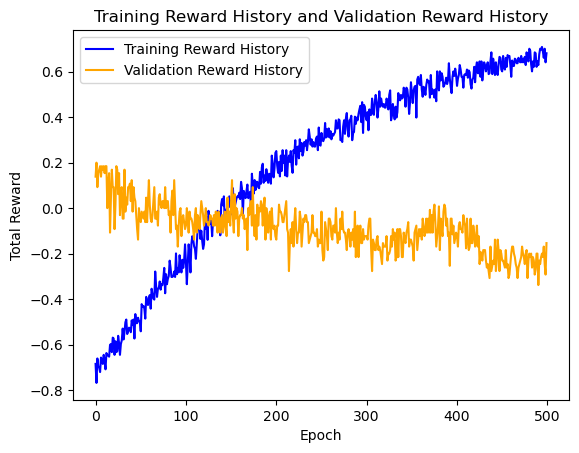

In [15]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

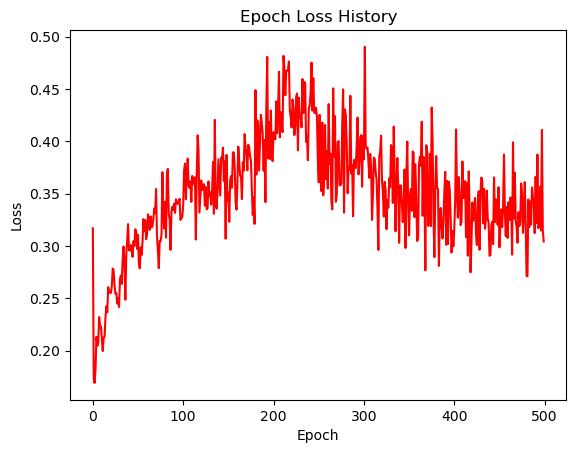

In [16]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Final win rates:  0.8406374501992032
Final loss rates:  0.0697211155378486
Final forced rates:  0.0
Final none rates:  0.08964143426294821


Text(0.5, 0, 'Epoch')

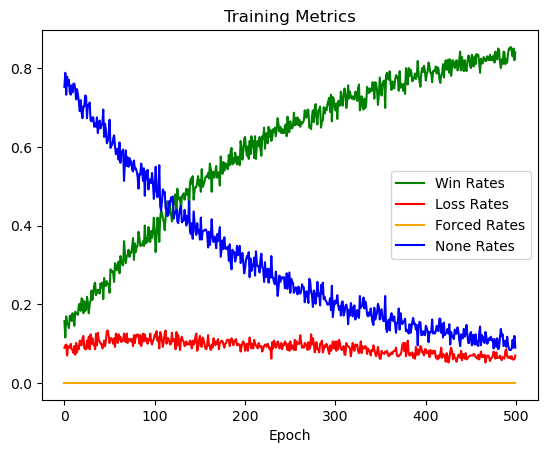

In [17]:
win_rates = training_metrics['win_rates']
loss_rates = training_metrics['loss_rates']
forced_rates = training_metrics['forced_rates']
none_rates = training_metrics['no_trade_rates']

print("Final win rates: ", win_rates[-1])
print("Final loss rates: ", loss_rates[-1])
print("Final forced rates: ", forced_rates[-1])
print("Final none rates: ", none_rates[-1])


plt.plot(win_rates, color = 'green',label = 'Win Rates')
plt.plot(loss_rates, color = 'red', label = 'Loss Rates')
plt.plot(forced_rates, color = 'orange', label = 'Forced Rates')
plt.plot(none_rates, color = 'blue', label = 'None Rates')

plt.legend()
plt.title('Training Metrics')
plt.xlabel('Epoch') 

# Evaluate
---

In [18]:
#Recreate the model and load the saved state_dict
online_net_trained = DQN(input_dim=6, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))



/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_14098/1965127732.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  online_net_trained.load_state_dict(torch.load

RuntimeError: Error(s) in loading state_dict for DQN:
	size mismatch for net.0.weight: copying a param with shape torch.Size([64, 13]) from checkpoint, the shape in current model is torch.Size([64, 6]).

In [17]:
tx_cost = 0.000

#TEST SET
test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
    online_net_trained,
    zscore_series_test,
    prices_test,
    beta_series_test,
    initial_capital,
    tx_cost,
    entry_stop_pairs,
)
print(test_metrics)

#TRAINING SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_train,
#     prices_train,
#     beta_series_train,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)

#VALIDATION SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_val,
#     prices_val,
#     beta_series_val,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)



{'avg_reward': -0.03773584905660377, 'win_rate': 0.4811320754716981, 'loss_rate': 0.2830188679245283, 'forced_rate': 0.0, 'no_trade_rate': 0.2358490566037736}


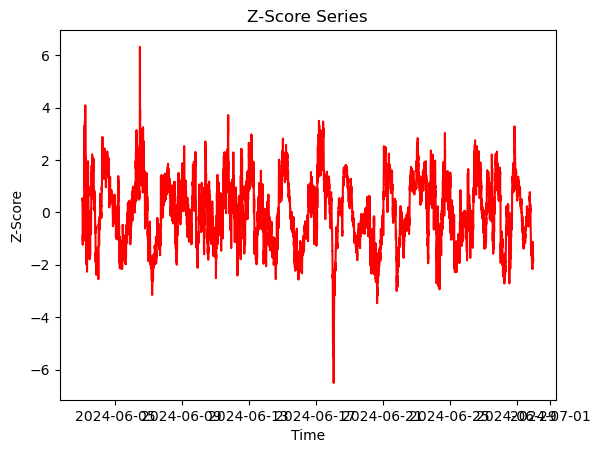

In [18]:
plt.plot(zscore_series_test, color = 'red')
plt.title('Z-Score Series')
plt.xlabel('Time')
plt.ylabel('Z-Score')
plt.show()

In [19]:
len(trade_profits)  

106

In [20]:
actions_profits_list = zip(actions,trade_profits)
actions_profits_df = pd.DataFrame(actions_profits_list, columns=['Actions', 'Trade Profits'])

#Show all rows
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# actions_profits_df_zeros = actions_profits_df[actions_profits_df['Trade Profits'] > 0]
#actions_profits_df_zeros

actions_profits_df

,Actions,Trade Profits
0,"(1, 2)",15.544209
1,"(1, 2)",-21.632868
2,"(1, 2)",0.000000
3,"(2, 3)",38.861639
4,"(1, 2)",-21.575084
...,...,...
101,"(3, 4)",0.000000
102,"(2, 3)",13.624508
103,"(1, 2)",0.000000
104,"(2, 3)",-25.757661


percentages:  [67.9245283018868, 21.69811320754717, 10.377358490566039]


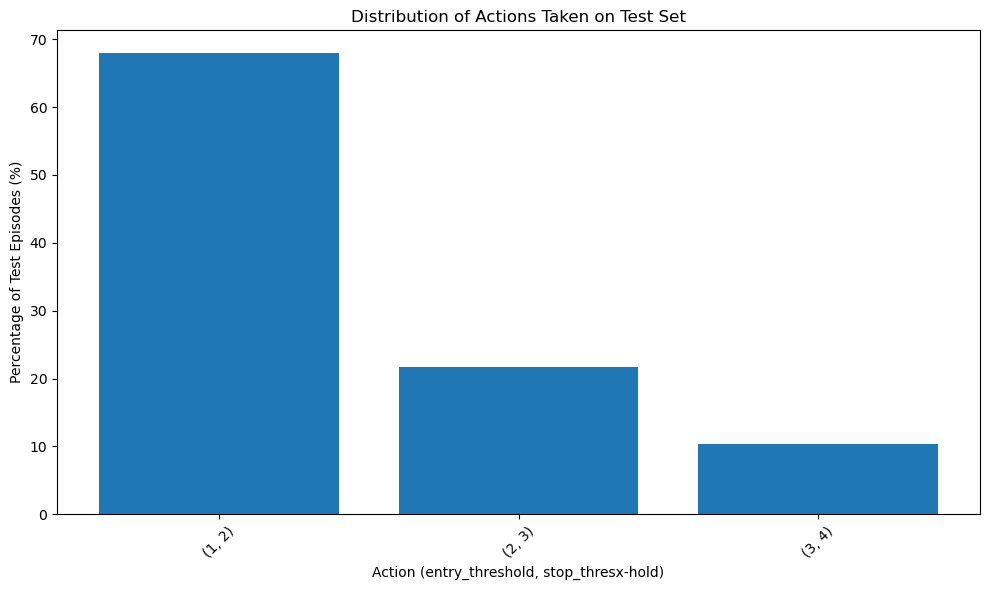

In [21]:
#Count number of each action in the actions list
from collections import Counter

# 1. Count how many times each action appears
counts = Counter(actions)
total = len(actions)

# 2. Compute percentages
actions_sorted = sorted(counts.keys())
percentages = [counts[a] / total * 100 for a in actions_sorted]

print("percentages: ", percentages)


# 4. Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(actions_sorted)), percentages)
plt.xticks(range(len(actions_sorted)), [f"{a}" for a in actions_sorted], rotation=45)
plt.ylabel("Percentage of Test Episodes (%)")
plt.xlabel("Action (entry_threshold, stop_thresx-hold)")
plt.title("Distribution of Actions Taken on Test Set")
plt.tight_layout()
plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  4.,  2.,  3.,  3.,  3.,  2.,  5.,  1.,  0.,
         2.,  0.,  1., 26.,  0.,  0.,  0.,  1.,  6.,  6.,  8.,  6.,  3.,
         4.,  4.,  2.,  1.,  4.,  1.,  1.,  0.,  0.,  1.,  1.]),
 array([-6.23670023e+01, -6.02867583e+01, -5.82065144e+01, -5.61262704e+01,
        -5.40460264e+01, -5.19657824e+01, -4.98855384e+01, -4.78052945e+01,
        -4.57250505e+01, -4.36448065e+01, -4.15645625e+01, -3.94843186e+01,
        -3.74040746e+01, -3.53238306e+01, -3.32435866e+01, -3.11633427e+01,
        -2.90830987e+01, -2.70028547e+01, -2.49226107e+01, -2.28423668e+01,
        -2.07621228e+01, -1.86818788e+01, -1.66016348e+01, -1.45213908e+01,
        -1.24411469e+01, -1.03609029e+01, -8.28065891e+00, -6.20041494e+00,
        -4.12017096e+00, -2.03992698e+00,  4.03169925e-02,  2.12056097e+00,
         4.20080495e+00,  6.28104892e+00,  8.36129290e+00,  1.04415369e+01,
         1.25217809e+01,  1.4602

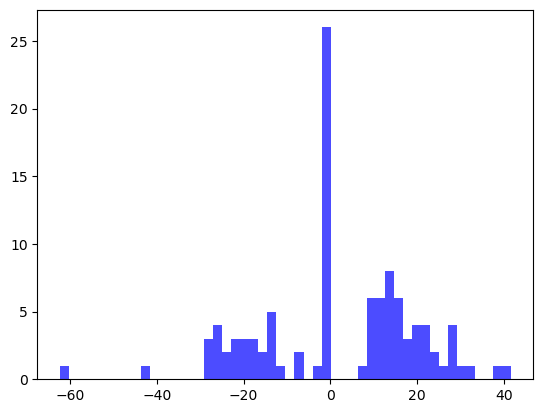

In [22]:
plt.hist(trade_profits, bins=50, color='blue', alpha=0.7)

Final returns:  2.3924467507171423 %


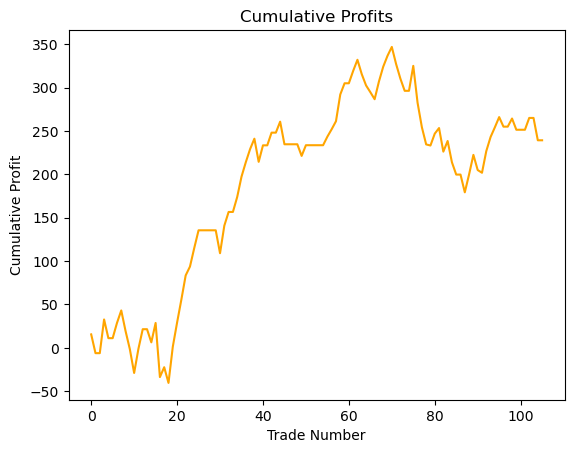

In [23]:
cumulative_profits = np.cumsum(trade_profits)
print("Final returns: ", cumulative_profits[-1]/initial_capital * 100, "%")
plt.plot(cumulative_profits, color='orange')
plt.title('Cumulative Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')
plt.show()

[20.628936285103222, 15.544209333949873, -21.632867662720002, -9.469379059075383, -21.57508408983181, 32.39920204867969, 17.46927725112883, 14.467981153005262, -23.69829275425726, -20.948541327542284, -27.428030070205182, 27.923680540597033, 22.53935455541169, 18.706183839511972, -15.152291456564964, 22.329943273108107, -5.926726886188326, 11.38118456445208, -18.099172492464554, 59.207527997234166, 41.6451965272061, 27.93126079116665, 26.544534633363448, 27.785103480641276, 10.180818642857858, 21.438549024137423, 20.364176299964498, 14.573430944151347, -26.987276262418703, 16.336848555739273, 17.377499776969366, -26.426871060155136, -21.416068733430944, 15.816268754117775, 16.342048954044376, 17.278455923163918, -10.071907206268698, 16.65100342116487, 15.115464571501331, 11.99624892708918, -26.66431289046502, 19.021809971918124, 15.419332657385253, 14.621534916270083, 10.588412345406617, -8.509870156350317, 14.027757426525673, 14.033177175023226, 13.916632535970908, -13.41201453648565,

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_1453/3596984610.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")


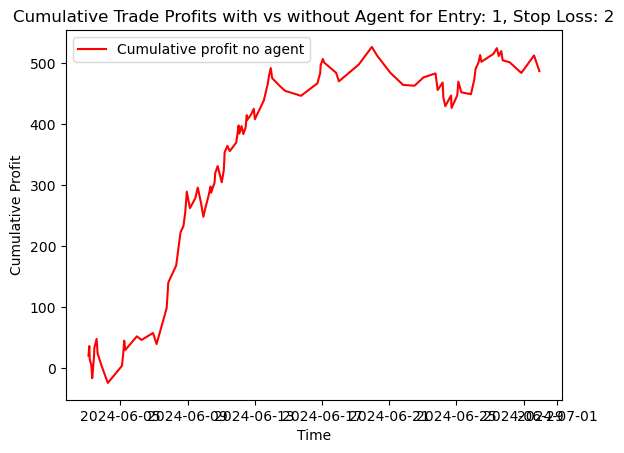

[-4.397513480369991, 38.86163871870074, 21.270220367462805, 41.91710334866478, 22.325591132441502, 27.164257651239495, -14.526649893109726, -10.670521400762945, -33.71916278324656, 40.08279749367327, 36.00436650866091, 31.763476009528745, 23.363813942726445, 20.43004092574685, 12.647687406134061, -26.039710382503586, 24.59755999449682, 25.80589311706948, -4.647115202901713, 9.216713896398318, 29.56708738078965, -38.91632047282147, -2.473882664921291, -24.541668279181643, -19.730830821421787, -17.691191778773966, -42.52442315378245, 34.56580725018988, -22.542697127829577, 19.386588601248377, 17.29847101640724, 40.041203490756004, 20.82813136157359, -18.21875941768134, -10.560651576858241, 18.132717612380382, 24.27317860327434, 30.45411052356618, 13.624507881055433, 40.432989519986826, -25.757660639570744, -0.679215712146334]
Number of trades:  42
Percentage_Return:  3.4641797896628876 %


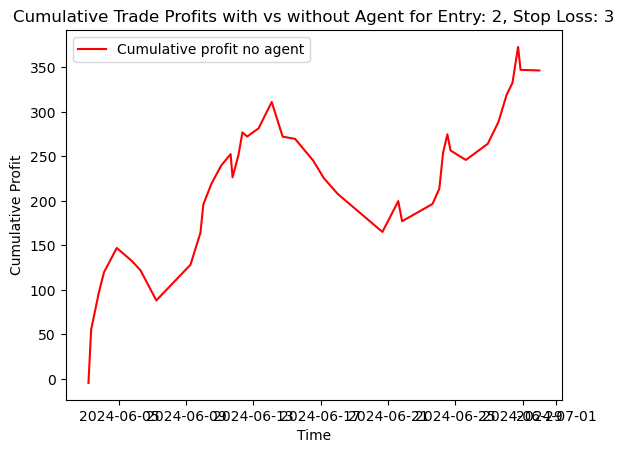

[47.309458176623224, -62.3670023095881, -9.73580448001519, 32.40774421877961, -95.12152069127004, -40.78061678529934, 17.492780501139507, 45.558213405936804, 14.005877594808055, 42.11104898573251]
Number of trades:  10
Percentage_Return:  -0.09119821383152953 %


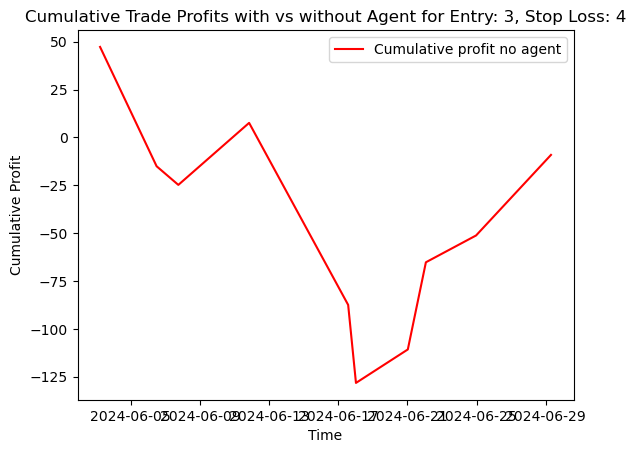

[62.33866669478057, -15.738791926110622]
Number of trades:  2
Percentage_Return:  0.46599874768669947 %


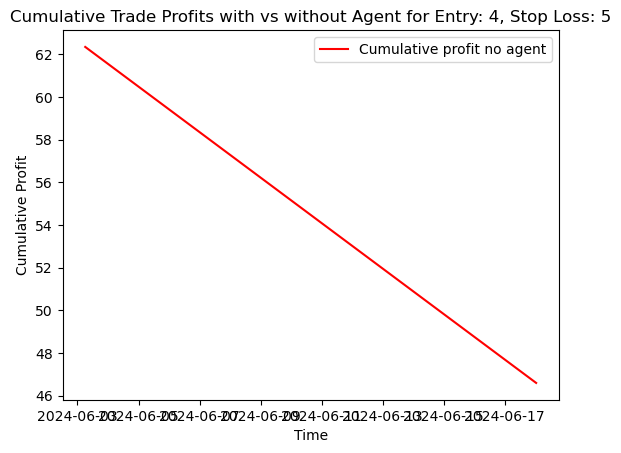

[-110.22431890638507]
Number of trades:  1
Percentage_Return:  -1.1022431890638507 %


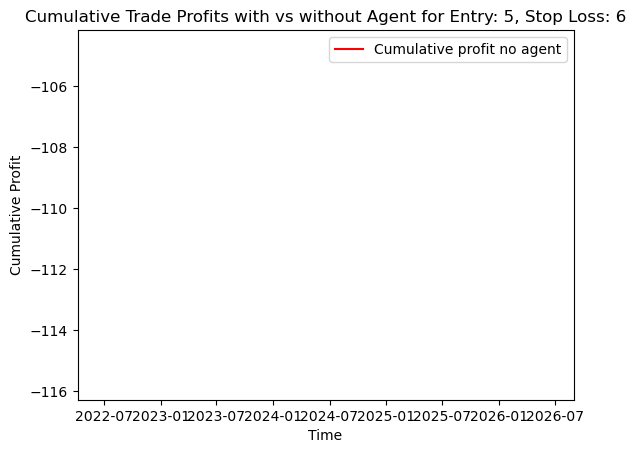

[44.508601669991776, 2.0780868184322685]
Number of trades:  2
Percentage_Return:  0.4658668848842405 %


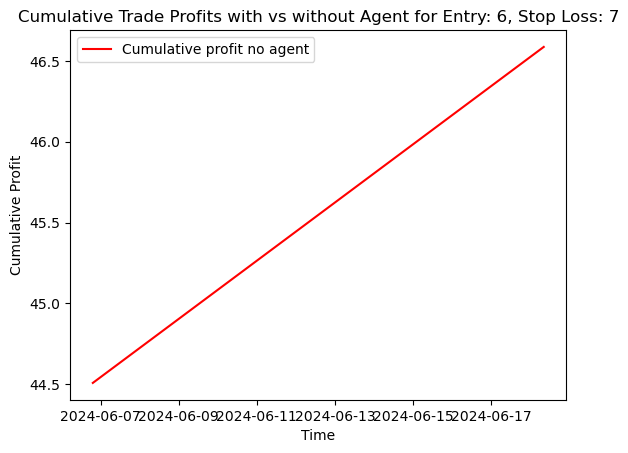

In [24]:

exit_threshold = 0
#tx_cost = 0.00025

#entry_stop_pairs = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

for entry_stop_pair in entry_stop_pairs:
    entry_threshold, stop_loss_threshold = entry_stop_pair
    
    #TEST DATA
    #----------
    positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
    trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

    # #TRAIN DATA
    # #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_train, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_train, tx_cost)

    # #VAL DATA
    # #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_val,S2_val,zscore_series_val, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_val, tx_cost)

    print(trade_profits_no_agent)
    #cumulative_profit_series_no_agent_indexed = cumulative_profit_series_no_agent.reindex(prices_test.index, method='ffill').fillna(0)
    print("Number of trades: ", len(trade_profits_no_agent))
    #print(cumulative_profit_series_no_agent)
    plt.plot(cumulative_profit_series_no_agent, color = 'red', label = 'Cumulative profit no agent') #Cumulative profits without agent
    print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")
    plt.title(f'Cumulative Trade Profits with vs without Agent for Entry: {entry_threshold}, Stop Loss: {stop_loss_threshold}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Profit')
    plt.legend()
    plt.show()